In [2]:
#!pip install keras-tuner
import numpy as np
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

In [3]:
def data():
    '''
    Function to preprocess the data with reshape, normalization, labelling and returning 
    train and validation datasets
    '''
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_val, y_train, y_val = train_test_split(X_train,    y_train, test_size=0.2, random_state=12345)
    X_train = X_train.reshape(48000, 784)
    X_val = X_val.reshape(12000, 784)
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255.0
    X_val /= 255.0
    nb_classes = 10
    Y_train = keras.utils.to_categorical(y_train, nb_classes)
    Y_val = keras.utils.to_categorical(y_val, nb_classes)
    return X_train, Y_train, X_val, Y_val

In [4]:
X_train, Y_train, X_val, Y_val = data()

In [5]:
#part-1 feed forward neural network
feed_forward_model = tf.keras.models.Sequential()
feed_forward_model.add(tf.keras.Input(shape = (784,)))
feed_forward_model.add(tf.keras.layers.Dense(500,activation='relu'))
feed_forward_model.add(keras.layers.Dense(units = 200, activation = 'relu'))
feed_forward_model.add(keras.layers.Dense(units = 50, activation = 'relu'))
feed_forward_model.add(keras.layers.Dense(units = 10, activation = 'softmax'))

In [6]:
feed_forward_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = feed_forward_model.fit(X_train, Y_train, epochs=5, batch_size=30, validation_data = (X_val, Y_val))

Epoch 1/5
1600/1600 [==============================] - 8s 5ms/step - loss: 0.5024 - accuracy: 0.8165 - val_loss: 0.4073 - val_accuracy: 0.8494
Epoch 2/5
1600/1600 [==============================] - 8s 5ms/step - loss: 0.3791 - accuracy: 0.8612 - val_loss: 0.3392 - val_accuracy: 0.8803
Epoch 3/5
1600/1600 [==============================] - 7s 5ms/step - loss: 0.3410 - accuracy: 0.8735 - val_loss: 0.3410 - val_accuracy: 0.8806
Epoch 4/5
1600/1600 [==============================] - 8s 5ms/step - loss: 0.3160 - accuracy: 0.8825 - val_loss: 0.3019 - val_accuracy: 0.8885
Epoch 5/5
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2948 - accuracy: 0.8906 - val_loss: 0.3219 - val_accuracy: 0.8891


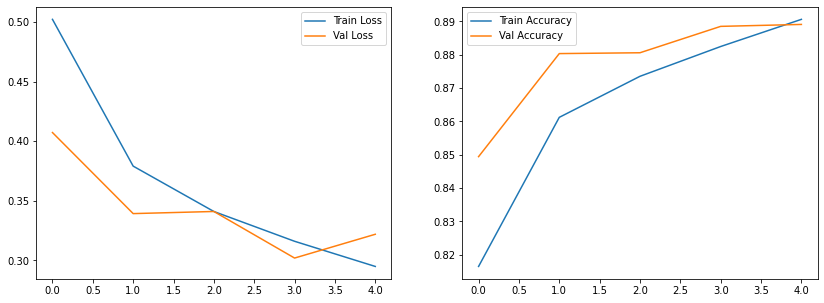

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.legend()
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
ax2.legend()

In [9]:
#part2 
#i) single hidden layer with varied neurons/nodes
def nn_with_neurons(hp):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(784,)))
    #providing range for number of neurons in a hidden layer
    model.add(keras.layers.Dense(units=hp.Int('num_of_neurons',min_value=32,max_value=512,step=32),
                                    activation='sigmoid'))
    #output layer
    model.add(keras.layers.Dense(10,activation='softmax'))
    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [13]:
#feeding the model and parameters to Random Search
tuner=RandomSearch(nn_with_neurons,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='hptuning1')

In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_of_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [15]:
tuner.search(X_train,Y_train,epochs=10,validation_data=(X_val,Y_val))

Trial 5 Complete [00h 03m 17s]
val_accuracy: 0.8987222115198771

Best val_accuracy So Far: 0.8987222115198771
Total elapsed time: 00h 16m 00s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.results_summary() #best number of neurons

Results summary
Results in my_dir/hptuning1
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_of_neurons: 448
learning_rate: 0.001
Score: 0.8987222115198771
Trial summary
Hyperparameters:
num_of_neurons: 480
learning_rate: 0.001
Score: 0.8958333532015482
Trial summary
Hyperparameters:
num_of_neurons: 448
learning_rate: 0.0001
Score: 0.8696944316228231
Trial summary
Hyperparameters:
num_of_neurons: 192
learning_rate: 0.0001
Score: 0.8659999767939249
Trial summary
Hyperparameters:
num_of_neurons: 480
learning_rate: 0.01
Score: 0.8422222336133321


In [17]:
#part2 
#ii) single hidden layer with multiple activation functions
def nn_with_activations(hp):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(784,)))
    #providing best number of neurons from the above experiment
    model.add(keras.layers.Dense(units=448,activation=hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid','softmax'],default='relu')))
    #output layer
    model.add(keras.layers.Dense(10,activation='softmax'))
    #compiling the model
    model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [18]:
#feeding the model and parameters to Random Search
tuner2=RandomSearch(nn_with_activations,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hptuning2')

In [19]:
tuner2.search_space_summary()

Search space summary
Default search space size: 1
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'softmax'], 'ordered': False}


In [20]:
tuner2.search(X_train,Y_train,epochs=10,validation_data=(X_val,Y_val))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
dense_activation  |relu              |?                 

Epoch 1/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5002 - accuracy: 0.8202 - val_loss: 0.3815 - val_accuracy: 0.8639
Epoch 2/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3754 - accuracy: 0.8616 - val_loss: 0.3357 - val_accuracy: 0.8771
Epoch 3/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3368 - accuracy: 0.8757 - val_loss: 0.3385 - val_accuracy: 0.8782
Epoch 4/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3140 - accuracy: 0.8838 - val_loss: 0.3392 - val_accuracy: 0.8793
Epoch 5/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2918 - accuracy: 0.8905 - val_loss: 0.3115 - val_accuracy: 0.8904
Epoch 6/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2777 - accuracy: 0.8973 - val_loss: 0.3090 - val_accuracy: 0

KeyboardInterrupt: ignored

In [85]:
tuner2.results_summary()

Results summary
Results in my_dir/cc
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_activation: relu
Score: 0.8991666734218597
Trial summary
Hyperparameters:
dense_activation: sigmoid
Score: 0.8978750109672546
Trial summary
Hyperparameters:
dense_activation: softmax
Score: 0.7928749918937683


In [91]:
#part2 
#iii) hyperparameter tuning with layers and neurons
def nn_with_layers_neurons(hp):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(784,)))
    #providing range for number of neurons in a hidden layer
    for i in range(hp.Int('num_of_layers',2,20)):         
        #providing range for number of neurons in hidden layers
        model.add(keras.layers.Dense(units=hp.Int('num_of_neurons'+ str(i),min_value=32,max_value=512,step=32),
                                    activation='relu'))
    #output layer
    model.add(keras.layers.Dense(10,activation='softmax'))
    #compiling the model
    model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [93]:
#feeding the model and parameters to Random Search
tuner3=RandomSearch(nn_with_layers_neurons,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hptuning3')

INFO:tensorflow:Reloading Oracle from existing project my_dir/cc/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/cc/tuner0.json


In [94]:
tuner3.search_space_summary()

Search space summary
Default search space size: 1
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'softmax'], 'ordered': False}


In [95]:
tuner3.search(X_train,Y_train,epochs=10,validation_data=(X_val,Y_val))

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner3.results_summary()